# Setup

In [1]:
import pandas as pd
import numpy as np

import os
import pathlib
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(pathlib.Path("__file__").parent.resolve()) + "\\gcp_private_key.json"

from google.cloud import bigquery
bq_client = bigquery.Client()

# send a query to bigquery
def query(client, q):
    query_results = client.query(q)
    
    if query_results.errors == None:
        return query_results.to_dataframe()
    else:
        for error in query_results.errors:
            print("[%s] %s" % (error["reason"], error["message"]))
        
        return None
    
# query bigquery and save the results to a new table
def create_table(client, q, dataset, table,):
    table_loc = "fyp-mimic.%s.%s" % (dataset, table)
    create_q = "DROP TABLE IF EXISTS `%s`; CREATE TABLE `%s` AS(%s);" % (table_loc, table_loc, q)
    query(client, create_q)
    
# read a sql script in as a single string
def read_sql(script_name):
    q = ""
    with open("SQL/%s.sql" % script_name, "r") as file:
        q = file.read()
    return q

# converters to switch between pm4py event log and pandas dataframe formats 
from pm4py.objects.conversion.log import converter as log_converter

# convert from a pandas dataframe to an pm4py event log
def df_to_elog(df):
    df_to_convert = df.copy()
    df_to_convert = df_to_convert.rename(columns={
        "EVENT_TIMESTAMP": "time:timestamp", 
        "ICUSTAY_ID": "case:concept:name",
        "ACTIVITY": "concept:name"
    })
    df_to_convert = df_to_convert.sort_values("time:timestamp")

    log = log_converter.apply(df_to_convert)
    
    return log

# convert a pm4py event log to a pandas data frame
def log_to_df(log):
    df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
    df = df.rename(columns={
        "time:timestamp": "EVENT_TIMESTAMP", 
        "case:concept:name": "ICUSTAY_ID",
        "concept:name": "ACTIVITY"
    })
    
    return df

# Extraction and Initial Data Processing

These queries are used to create the initial data tables in BigQuery.

## Event Log Tables

These tables prepare all of the information that is needed for the event log.

In [2]:
# AKI stages
create_table(bq_client, read_sql("AKI_Stages"), "aki_model", "aki_stages")

In [3]:
# Red blood cell transfusions
create_table(bq_client, read_sql("RBC_Transfusions"), "aki_model", "rbc_transfusions")

In [4]:
# Colloid boluses
create_table(bq_client, read_sql("Colloid_Bolus"), "aki_model", "colloid_bolus")

In [5]:
# Crystalloid boluses
create_table(bq_client, read_sql("Crystalloid_Bolus"), "aki_model", "crystalloid_bolus")

In [6]:
# ICU stays key events
create_table(bq_client, read_sql("ICU_Stay_Key_Events"), "aki_model", "icu_key_events")

In [7]:
# ICU stays mapping table
create_table(bq_client, read_sql("ICU_Stays_Extract"), "aki_model", "icustays")

## Cases Tables

These queries prepare all of the information that is needed for the Cases table.

In [8]:
# ICU stay details
create_table(bq_client, read_sql("ICU_Stay_Details"), "aki_model", "icustay_details")

In [9]:
# OASIS Score
create_table(bq_client, read_sql("OASIS_Extraction"), "aki_model", "oasis_extraction")

In [10]:
# SOFA renal scores
create_table(bq_client, read_sql("SOFA_Extraction"), "aki_model", "sofa_renal_extraction")

In [11]:
# BMI
create_table(bq_client, read_sql("BMI_Extract"), "aki_model", "bmi_extraction")

In [12]:
# Elixhauser scores
create_table(bq_client, read_sql("Elixhauser_Scores_Extract"), "aki_model", "elixhauser_scores_extraction")

In [13]:
# Diagnosis group
create_table(bq_client, read_sql("Diagnosis_Group"), "aki_model", "diagnosis_group")

## Create Model Tables

These queries combine all of the prepared tables into the final data model.

In [14]:
# cases
create_table(bq_client, read_sql("AKI_Dimensions"), "aki_model", "aki_dimensions")

In [15]:
# elixhauser flags
create_table(bq_client, read_sql("Elixhauser_Extract"), "aki_model", "elixhauser")

In [16]:
# event log
create_table(bq_client, read_sql("AKI_Event_Log"), "aki_model", "aki_event_log")

# Data Processing Definitions

Define some of the structures that will be used for processing in the iterative cycles.

Also, load in all the data we need from BigQuery.

In [17]:
elog_dl = query(bq_client, "SELECT * FROM `fyp-mimic.aki_model.aki_event_log`")

In [18]:
cases_dl = query(bq_client, "SELECT * FROM `fyp-mimic.aki_model.aki_dimensions`")

In [19]:
diag_dl = query(bq_client, "SELECT * FROM `fyp-mimic.fyp_extracts.diagnoses_icd`")

## Prerenal AKI Filter

We want to be able to filter to only patients that have prerenal AKI and exclude any patients that have AKI from other causes.

We start by computing which admissions contain patients with AKI, prerenal causes of AKI, intrinsic causes of AKI, and postrenal causes of AKI. We then define a function which will add this information to the cases table.

In [20]:
# Load in a mapping of every ICD-9 code to higher level categories, for convenience
map_dl = pd.read_csv("../Data/ICD9 Mapping/ICD9_Category_Mapping.csv", names=["ICD9_CODE", "L1_CAT", "L2_CAT", "L3_CAT"])

# There is an issue with some codes not having leading 0s so we fix that here
map_dl["ICD9_CODE"] = map_dl["ICD9_CODE"].mask(map_dl["L2_CAT"].isin([
    "Intestinal Infectious Diseases",
    "Tuberculosis",
    "Zoonotic Bacterial Diseases",
    "Other Bacterial Diseases",
    "Human Immunodeficiency Virus",
    "Poliomyelitis And Other Non-Arthropod-Borne Viral Diseases Of Central Nervous System",
    "Viral Diseases Accompanied By Exanthem",
    "Arthropod-Borne Viral Diseases",
    "Other Diseases Due To Viruses And Chlamydiae",
    "Rickettsioses And Other Arthropod-Borne Diseases",
    "Syphilis And Other Venereal Diseases"
]), "0" + map_dl["ICD9_CODE"])

In [21]:
# Find admissions that have AKI as a listed diagnosis
aki_filter = map_dl[
    (map_dl["L3_CAT"] == "Acute kidney failure") # AKI
]
aki_listed_filter_admissions = aki_filter.merge(diag_dl, left_on="ICD9_CODE", right_on="ICD9_CODE")["HADM_ID"].unique()

# Find admissions that have prerenal causes of AKI listed in their diagnoses
prerenal_filter = map_dl[
    (map_dl["ICD9_CODE"] == "27652") | # Hypovolemia https://en.wikipedia.org/wiki/Hypovolemia
    (map_dl["L3_CAT"] == "Hypotension") | # Hypotension https://en.wikipedia.org/wiki/Hypotension
    (map_dl["ICD9_CODE"] == "7963") | # Hypotension https://en.wikipedia.org/wiki/Hypotension
    (map_dl["ICD9_CODE"] == "4280") | # Heart failure https://en.wikipedia.org/wiki/Heart_failure
    (map_dl["ICD9_CODE"] == "40490") | # Cardiorenal syndrome https://en.wikipedia.org/wiki/Cardiorenal_syndrome
    (map_dl["ICD9_CODE"] == "5724") | # Hepatorenal syndrome https://en.wikipedia.org/wiki/Hepatorenal_syndrome
    (map_dl["ICD9_CODE"] == "4401") | # Renal artery stenosis https://en.wikipedia.org/wiki/Renal_artery_stenosis
    (map_dl["ICD9_CODE"] == "4533") # Renal vein thrombosis https://en.wikipedia.org/wiki/Renal_vein_thrombosis
]
prerenal_filter_admissions = prerenal_filter.merge(diag_dl, left_on="ICD9_CODE", right_on="ICD9_CODE")["HADM_ID"].unique()

# Find admissions that have intrinsic causes of AKI listed in their diagnoses
intrinsic_filter = map_dl[
    (map_dl["L3_CAT"].isin(["Acute glomerulonephritis", "Nephrotic syndrome", "Chronic glomerulonephritis"])) | # Glomerulonephritis https://en.wikipedia.org/wiki/Glomerulonephritis
    (map_dl["ICD9_CODE"] == "5845") | # Acute tubular necrosis https://en.wikipedia.org/wiki/Acute_tubular_necrosis
    (map_dl["ICD9_CODE"] == "58389") | # Interstitial nephritis https://en.wikipedia.org/wiki/Interstitial_nephritis
    (map_dl["ICD9_CODE"] == "72888") | # Rhabdomyolysis https://en.wikipedia.org/wiki/Rhabdomyolysis
    (map_dl["ICD9_CODE"] == "27788") | # Tumor lysis syndrome https://en.wikipedia.org/wiki/Tumor_lysis_syndrome
    (map_dl["ICD9_CODE"] == "5846") | # Renal cortical necrosis https://en.wikipedia.org/wiki/Renal_cortical_necrosis
    (map_dl["ICD9_CODE"] == "5847") | # Renal papillary necrosis https://en.wikipedia.org/wiki/Renal_papillary_necrosis
    (map_dl["ICD9_CODE"] == "5848") # Other specified pathological lesion in kidney
]
intrinsic_filter_admissions = intrinsic_filter.merge(diag_dl, left_on="ICD9_CODE", right_on="ICD9_CODE")["HADM_ID"].unique()

# Find admissions that have postrenal causes of AKI listed in their diagnoses
postrenal_filter = map_dl[
    (map_dl["ICD9_CODE"].isin(["5996", "59960", "59969"])) | # Urinary tract obstruction https://en.wikipedia.org/wiki/Urinary_tract_obstruction
    (map_dl["L3_CAT"] == "Hyperplasia of prostate") | # Benign prostatic hyperplasia https://en.wikipedia.org/wiki/Benign_prostatic_hyperplasia
    (map_dl["L3_CAT"].isin(["Calculus of kidney and ureter", "Other disorders of kidney and ureter", "Calculus of lower urinary tract"])) | # Kidney stone disease https://en.wikipedia.org/wiki/Kidney_stone_disease
    (map_dl["ICD9_CODE"] == "99631") | # Mechanical complication due to urethral (indwelling) catheter
    (map_dl["L3_CAT"] == "Calculus of lower urinary tract") | # Bladder stone https://en.wikipedia.org/wiki/Bladder_stone
    (map_dl["L3_CAT"] == "Malignant neoplasm of bladder") | # Bladder cancer https://en.wikipedia.org/wiki/Bladder_cancer
    (map_dl["ICD9_CODE"].isin(["1892", "1893"])) | # Ureteral cancer https://en.wikipedia.org/wiki/Ureteral_cancer
    (map_dl["L3_CAT"] == "Malignant neoplasm of prostate") # Prostate cancer https://en.wikipedia.org/wiki/Prostate_cancer
]
postrenal_filter_admissions = postrenal_filter.merge(diag_dl, left_on="ICD9_CODE", right_on="ICD9_CODE")["HADM_ID"].unique()

In [22]:
def add_aki_cause_flags(cases_in):
    # Add flags for the presence of and the different causes of AKI
    cases = cases_in.copy()
    cases["AKI Listed Diagnosis Flag"] = cases["HADM_ID"].isin(aki_listed_filter_admissions)
    cases["Prerenal Causes Flag"] = cases["HADM_ID"].isin(prerenal_filter_admissions)
    cases["Intrinsic Causes Flag"] = cases["HADM_ID"].isin(intrinsic_filter_admissions)
    cases["Postrenal Causes Flag"] = cases["HADM_ID"].isin(postrenal_filter_admissions)
    return cases

## Diagnosis and Treatment Case Info

We need to be able to examine the diagnosis status of each case. Add the time of first AKI diagnosis to each case and also add a flag to indicate whether the case has a diagnosis or not.

In [23]:
def add_diagnosis_case_info(cases_in, elog):
    cases = cases_in.copy()
    
    aki_stages_all = elog[elog["ACTIVITY"].isin(["Tested as KDIGO AKI stage 0", "Tested as KDIGO AKI stage 1", "Tested as KDIGO AKI stage 2", "Tested as KDIGO AKI stage 3"])].copy()
    aki_stages_all["AKI Stage"] = pd.to_numeric(aki_stages_all["ACTIVITY"].str[-1])
    aki_stages_pos = aki_stages_all[aki_stages_all["AKI Stage"] != 0]
    first_aki_diagnoses = aki_stages_pos.loc[aki_stages_pos.groupby("ICUSTAY_ID")["EVENT_TIMESTAMP"].idxmin()].set_index("ICUSTAY_ID")
    first_aki_diagnosis_times = first_aki_diagnoses["EVENT_TIMESTAMP"].rename("First AKI Diagnosis Time")
    first_aki_diagnosis_stages = first_aki_diagnoses["AKI Stage"].rename("First AKI Stage")
    
    cases = cases.merge(first_aki_diagnosis_times, left_index=True, right_index=True, how="outer")
    cases = cases.merge(first_aki_diagnosis_stages, left_index=True, right_index=True, how="outer")
    cases["Has AKI Diagnosis"] = ~cases["First AKI Diagnosis Time"].isna()
    return cases

We need to be able to examine the treatment status of each case. Add the time of first AKI treatment to each case and also add a flag to indicate whether the case has a treatment or not.

In [24]:
def add_treatment_case_info(cases_in, elog):
    cases = cases_in.copy()
    
    aki_treatments = elog[elog["ACTIVITY"].isin(["Crystalloid bolus administered", "Colloid bolus administered", "Red blood cell transfusion administered", "Vasopressor administered", "AKI Treatment Given"])].copy()
    aki_treatments = aki_treatments.merge(cases["First AKI Diagnosis Time"], how="left", left_on="ICUSTAY_ID", right_index=True)
    # aki_treatments = aki_treatments[(aki_treatments["First AKI Diagnosis Time"] - pd.DateOffset(hours=6)) <= aki_treatments["EVENT_TIMESTAMP"]]
    # aki_treatments = aki_treatments[(aki_treatments["First AKI Diagnosis Time"] + pd.DateOffset(hours=6)) >= aki_treatments["EVENT_TIMESTAMP"]]
    aki_treatments = aki_treatments[aki_treatments["First AKI Diagnosis Time"] <= aki_treatments["EVENT_TIMESTAMP"]]
    first_aki_treatment_times = aki_treatments.groupby("ICUSTAY_ID")["EVENT_TIMESTAMP"].min().rename("First AKI Treatment Time")
    
    cases = cases.merge(first_aki_treatment_times, left_index=True, right_index=True, how="outer")
    
    return cases

## Successful Outcome Case Info

We need to be able to identify whether a case has a successful outcome or not. Add the time taken to reach a successful state for each case.

In [25]:
def add_success_case_info(cases_in, elog):
    cases = cases_in.copy()
    
    aki_stages_all = elog[elog["ACTIVITY"].isin(["Tested as KDIGO AKI stage 0", "Tested as KDIGO AKI stage 1", "Tested as KDIGO AKI stage 2", "Tested as KDIGO AKI stage 3"])].copy()
    aki_stages_all["AKI Stage"] = pd.to_numeric(aki_stages_all["ACTIVITY"].str[-1])
    aki_stages_all = aki_stages_all.merge(cases["First AKI Stage"], left_on="ICUSTAY_ID", right_index=True, how="left")
    aki_stages_all["AKI Stage Test"] = aki_stages_all["AKI Stage"] <= aki_stages_all["First AKI Stage"]
    final_det_times = aki_stages_all[aki_stages_all["AKI Stage Test"] == False].groupby("ICUSTAY_ID")["EVENT_TIMESTAMP"].max().rename("Final Deteriorated Time")
    aki_stages_all = aki_stages_all.merge(final_det_times, left_on="ICUSTAY_ID", right_index=True, how="left")
    earliest_stable_time = aki_stages_all[(aki_stages_all["AKI Stage Test"] == True) & (aki_stages_all["EVENT_TIMESTAMP"] >= aki_stages_all["Final Deteriorated Time"])].groupby("ICUSTAY_ID")["EVENT_TIMESTAMP"].min().rename("Earliest Successful State Time")
    
    cases = cases.merge(earliest_stable_time, left_index=True, right_index=True, how="left")
    cases["Time to Successful State"] = cases["Earliest Successful State Time"] - cases["First AKI Diagnosis Time"]
    
    return cases

# Mining and Analysis Iterations

Define a class to contain all the data about each iteration and a number of functions

In [26]:
import copy
import pm4py
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.dfg import dfg_filtering
from pm4py.statistics.traces.generic.log import case_statistics

class Iteration:
    def __init__(self, cases, pd_log=None, pm_log=None):
        if pd_log is None and pm_log is None:
            raise Error("Must specify either a pandas event log or a PM4Py event log.")
            
        self.set_cases(cases, False)
        if pd_log is None:
            self.set_pm_log(pm_log)
        else:
            self.set_pd_log(pd_log)
        self.remove_missing_cases()
            
    def set_cases(self, new_cases, remove_missing_cases=True):
        self.cases = new_cases.copy()
        
        if remove_missing_cases:
            self.remove_missing_cases()
            
    def set_pd_log(self, new_log, remove_missing_logs=True):
        self.pd_log = new_log
        self.pm_log = df_to_elog(new_log)
        
        if remove_missing_logs:
            self.remove_missing_logs()
        
    def set_pm_log(self, new_log, remove_missing_logs=True):
        self.pm_log = new_log
        self.pd_log = log_to_df(new_log)
        
        if remove_missing_logs:
            self.remove_missing_logs()
            
    def remove_missing_cases(self):
        new_log = self.pd_log[self.pd_log["ICUSTAY_ID"].isin(self.cases.index)]
        self.set_pd_log(new_log, False)
        
    def remove_missing_logs(self):
        new_cases = self.cases[self.cases.index.isin(self.pd_log["ICUSTAY_ID"])]
        self.set_cases(new_cases, False)
        
    def variants_ratio(self):
        num_cases = len(self.pm_log)
        num_variants = len(variants_filter.get_variants(self.pm_log))
        print("%d variants and %d cases (ratio of %.2f)" % (num_variants, num_cases, num_variants / num_cases))
        
    def get_variants(self):
        variants_count = case_statistics.get_variant_statistics(self.pm_log)
        variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
        variants = pd.DataFrame(variants_count).set_index(np.arange(1, len(variants_count) + 1)).rename(columns={
            "variant": "Variant",
            "count": "Count"
        })
        variants.index = variants.index.rename("Variant #")
        variants["Proportion"] = variants["Count"] / variants["Count"].sum()
        variants["Proportion (Cumulative)"] = variants["Proportion"].cumsum()
        
        return variants
        
    def discover_dfg_model(self, activities_pct=1.0, paths_pct=1.0):
        dfg, sa, ea = pm4py.discover_directly_follows_graph(self.pm_log)
        activities_count = pm4py.get_event_attribute_values(self.pm_log, "concept:name")

        dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_activities_percentage(dfg, sa, ea, activities_count, activities_pct)
        dfg, sa, ea, activities_count = dfg_filtering.filter_dfg_on_paths_percentage(dfg, sa, ea, activities_count, paths_pct)

        self.dfg = dfg
        self.sa = sa
        self.ea = ea
        self.activities_count = activities_count

    def view_dfg(self):
        pm4py.vis.view_dfg(dfg=self.dfg, start_activities=self.sa, end_activities=self.ea)
        
    def copy(self):
        return copy.deepcopy(self)
    
    def upgrade(self):
        cases_copy = self.cases.copy()
        log_copy = self.pd_log.copy()
        return Iteration(cases_copy, pd_log=log_copy)

Set up an initial iteration with some slight cleanup

In [27]:
elog = elog_dl.copy()
cases = cases_dl.copy().set_index("ICUSTAY_ID")
cases = cases[~cases.index.duplicated(keep="first")] # remove duplicate cases that have crept through      
i0 = Iteration(cases, pd_log=elog)
i0.remove_missing_cases()

## Iteration 1

### Data Processing

Start with the initial basic event log

In [28]:
# Start from the base log
i1 = i0.copy()

Remove any cases that are unlikely to be prerenal AKI by filtering the cases based on their cause of AKI.

In [29]:
# Add flags for the different causes of AKI
i1.set_cases(add_aki_cause_flags(i1.cases))

# Remove any cases that are unlikely to be prerenal AKI
i1.set_cases(i1.cases[
    (i1.cases["AKI Listed Diagnosis Flag"] == True) &
    (i1.cases["Prerenal Causes Flag"] == True) &
    (i1.cases["Intrinsic Causes Flag"] == False) &
    (i1.cases["Postrenal Causes Flag"] == False)
])

# Add info about the patient's first AKI diagnosis to the cases table
i1.set_cases(add_diagnosis_case_info(i1.cases, i1.pd_log))

# Remove any cases that do not have a positive AKI test
i1.set_cases(i1.cases[(i1.cases["Has AKI Diagnosis"] == True)])

There are two events with missing timestamps, so remove these events

In [30]:
i1.pd_log.isna().sum()

ICUSTAY_ID         0
EVENT_TIMESTAMP    2
ACTIVITY           0
dtype: int64

In [31]:
i1.set_pd_log(i1.pd_log.dropna())

### Mining and Analysis

There are 3679 different cases in the event log, and 3679 different variants. This means that every case is unique and that the cases are highly hetrogenous. We should prioritise simplifying them.

In [32]:
i1.variants_ratio()

3679 variants and 3679 cases (ratio of 1.00)


We create a DFG process model and notice a few issues:

1. We can see that the DFG process model is a spaghetti model, adding evidence to the heterogeneity mentioned above. We need to simplify this for it to become meaningful.
2. The process does not always start with ICU in
3. The process does not always end with ICU out or death

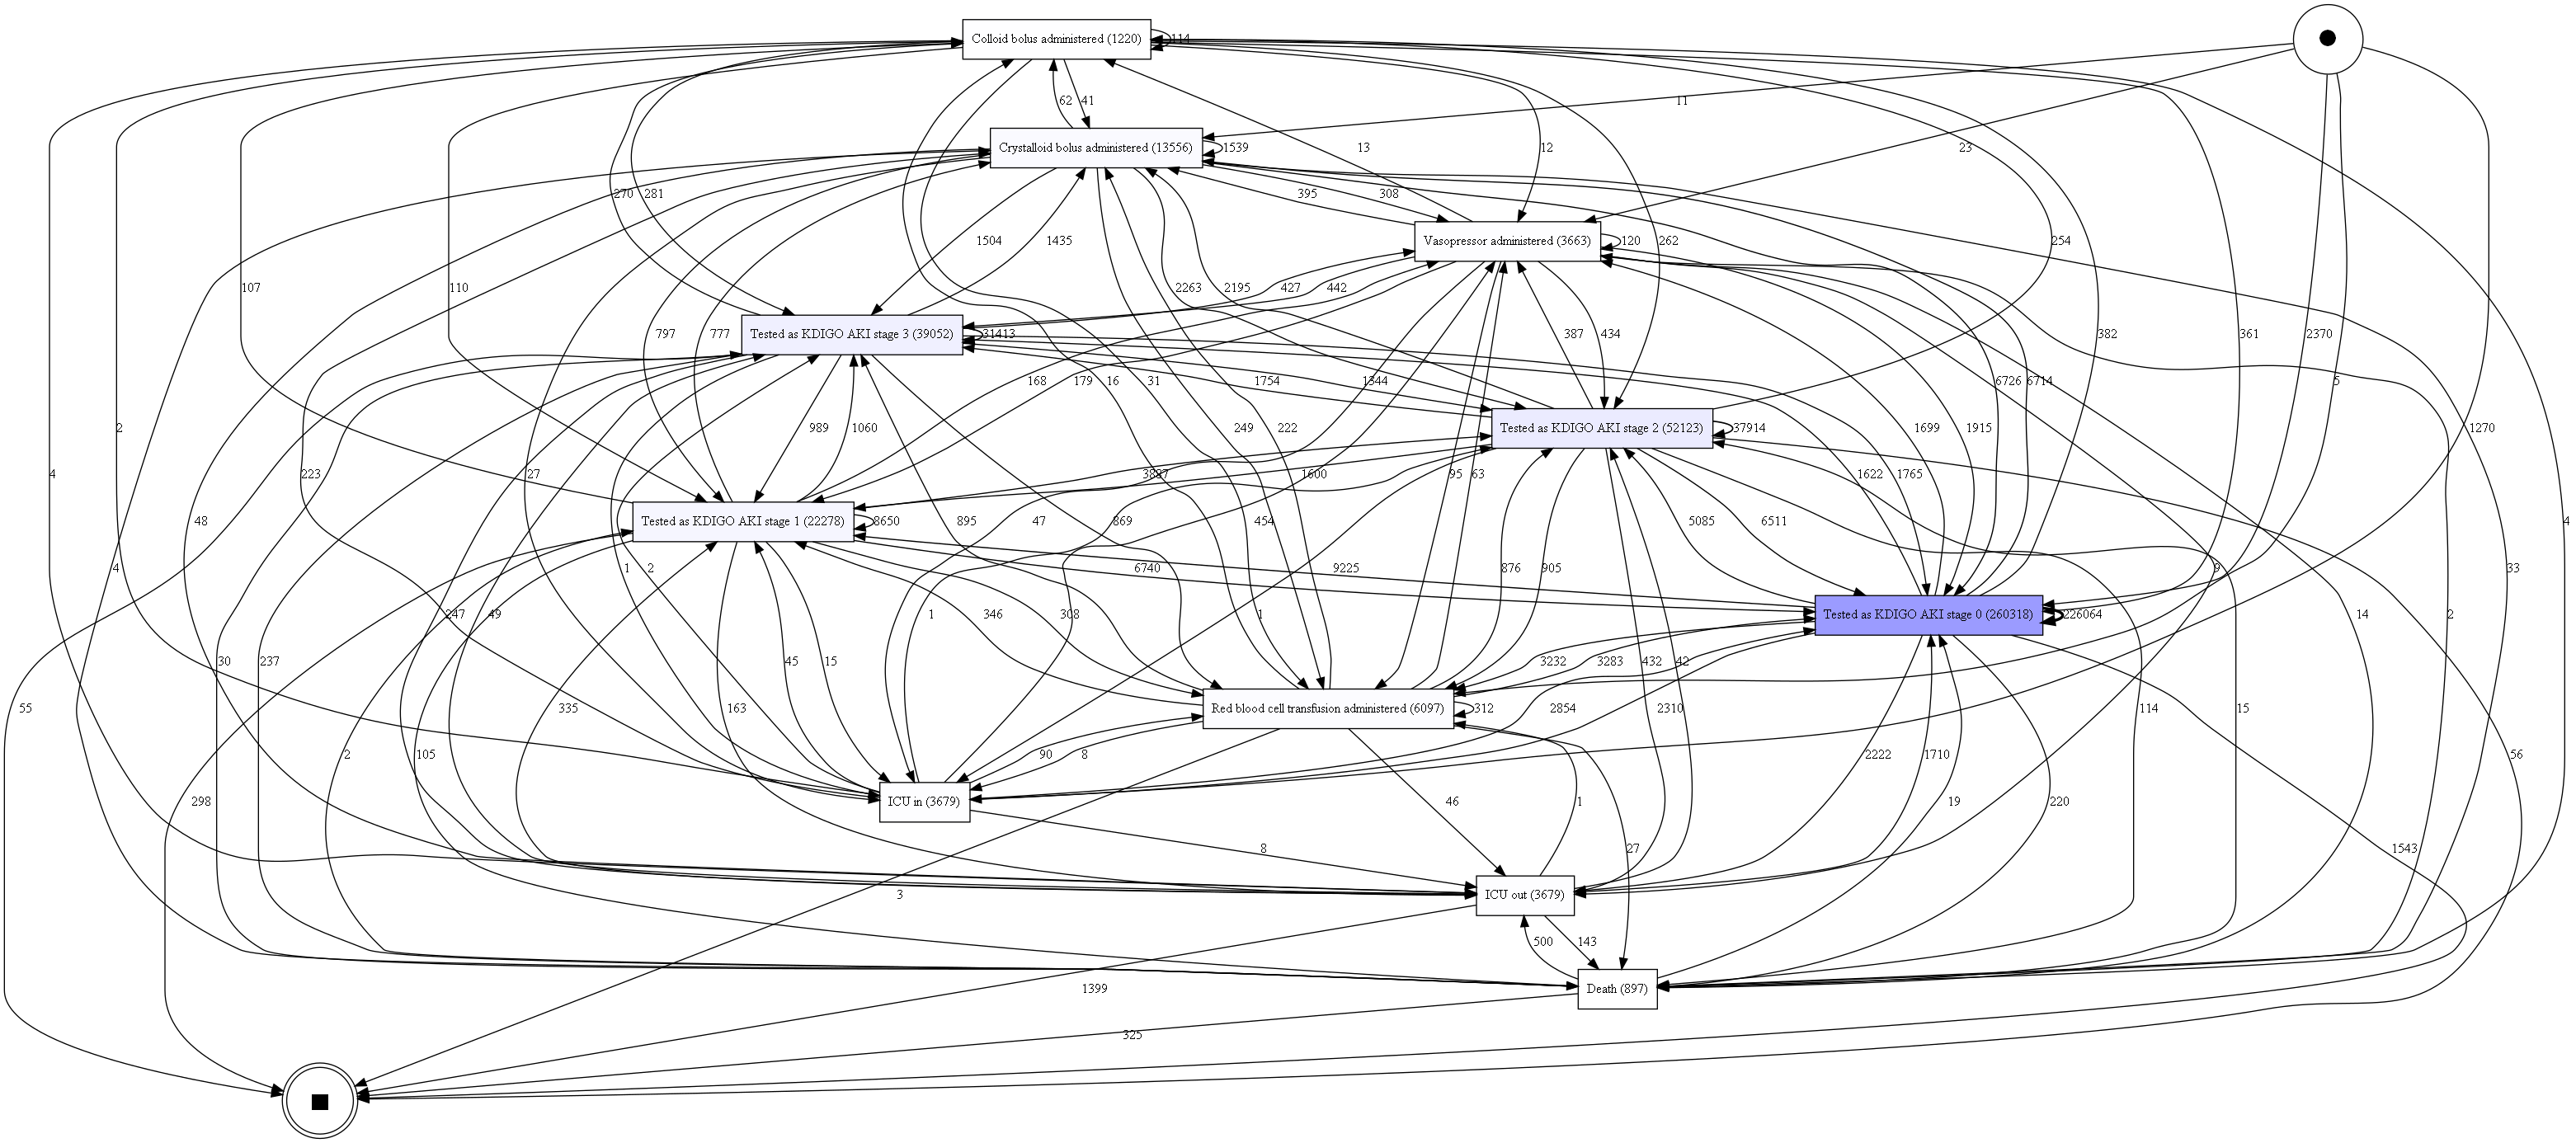

In [33]:
i1.discover_dfg_model()
i1.view_dfg()

Looking at the start and end activities, the main issue seems to be the AKI tests. These events are happening outside of the ICU stay. This could be a sign of a data quality issue.

In [34]:
i1.sa

{'Tested as KDIGO AKI stage 0': 2370,
 'ICU in': 1270,
 'Vasopressor administered': 23,
 'Red blood cell transfusion administered': 5,
 'Crystalloid bolus administered': 11}

In [35]:
i1.ea

{'Tested as KDIGO AKI stage 1': 298,
 'ICU out': 1399,
 'Tested as KDIGO AKI stage 0': 1543,
 'Death': 325,
 'Tested as KDIGO AKI stage 2': 56,
 'Tested as KDIGO AKI stage 3': 55,
 'Red blood cell transfusion administered': 3}

In order to deal with the heterogeneity, we note that we care most about AKI diagnosis and treatment, so we'll create general events for those and remove the some of the specific ones.

## Iteration 2

Remove all test events that are not the initial diagnosis.

### Data Processing

Start with the progress from the previous iteration.

In [36]:
# Start from iteration 1
i2 = i1.copy()

In [37]:
first_diagnosis_events = i2.cases["First AKI Diagnosis Time"].copy().rename("EVENT_TIMESTAMP").to_frame().reset_index()
first_diagnosis_events["ACTIVITY"] = "First AKI Diagnosis"

i2.set_pd_log(i2.pd_log[~i2.pd_log["ACTIVITY"].isin(["Tested as KDIGO AKI stage 0", "Tested as KDIGO AKI stage 1", "Tested as KDIGO AKI stage 2", "Tested as KDIGO AKI stage 3"])])
i2.set_pd_log(pd.concat([i2.pd_log, first_diagnosis_events]))

### Mining and Analysis

In [38]:
i2.variants_ratio()

1881 variants and 3679 cases (ratio of 0.51)


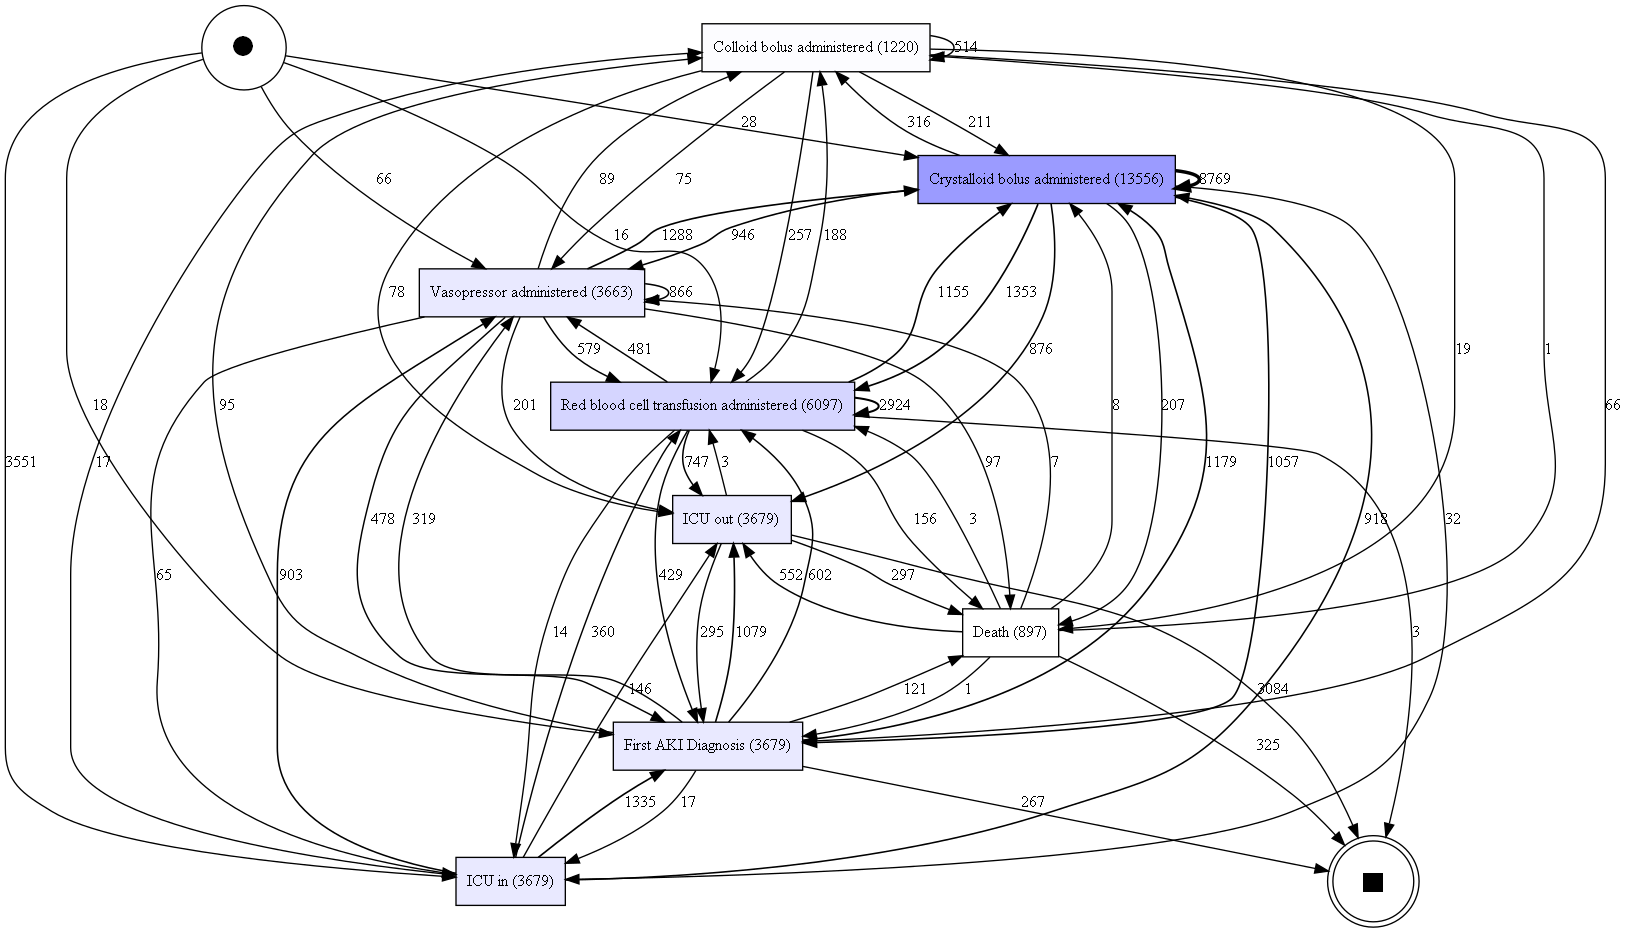

In [39]:
i2.discover_dfg_model()
i2.view_dfg()

## Iteration 3

Consolidate all the treatments under a single event name.

### Data Processing

In [40]:
# Start from iteration 2
i3 = i2.copy()

In [41]:
aki_treatment_activities = [
    "Crystalloid bolus administered",
    "Red blood cell transfusion administered",
    "Vasopressor administered",
    "Colloid bolus administered"
]
log_copy = i3.pd_log.copy()
log_copy["ACTIVITY"] = log_copy["ACTIVITY"].mask(log_copy["ACTIVITY"].isin(aki_treatment_activities), "AKI Treatment Given")
i3.set_pd_log(log_copy)

### Mining and Analysis

In [42]:
i3.variants_ratio()

703 variants and 3679 cases (ratio of 0.19)


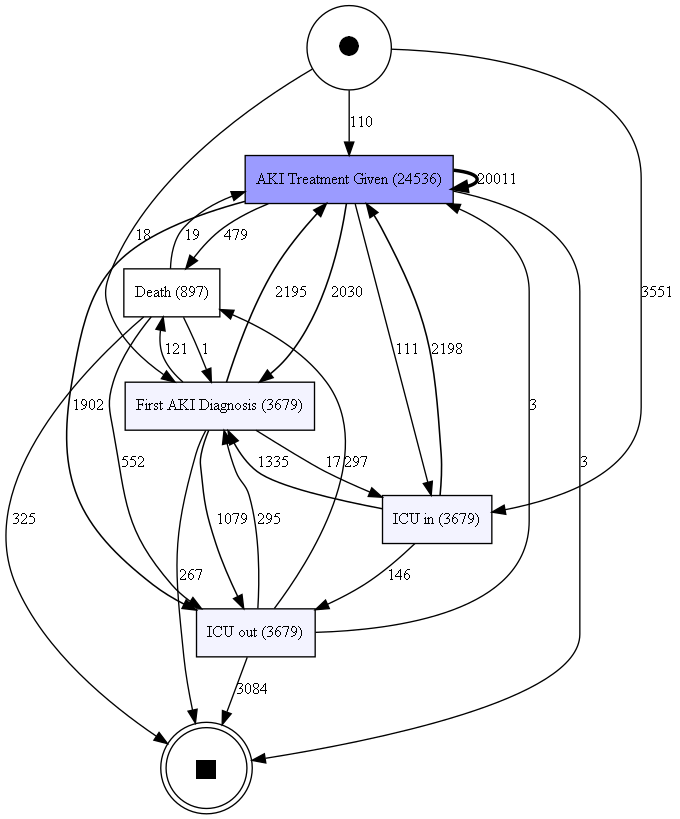

In [43]:
i3.discover_dfg_model()
i3.view_dfg()

## Iteration 4

Remove all treatment events apart from the first treatment for AKI.

### Data Processing

In [44]:
# Start from iteration 3
i4 = i3.copy()

In [45]:
# Add info about the patient's first AKI diagnosis to the cases table
i4.set_cases(add_treatment_case_info(i4.cases, i4.pd_log))

first_treatment_events = i4.cases[~(i4.cases["First AKI Treatment Time"].isna())]["First AKI Treatment Time"].copy().rename("EVENT_TIMESTAMP").to_frame().reset_index()
first_treatment_events["ACTIVITY"] = "First AKI Treatment"

i4.set_pd_log(i4.pd_log[~i4.pd_log["ACTIVITY"].isin(["AKI Treatment Given"])])
i4.set_pd_log(pd.concat([i4.pd_log, first_treatment_events]))

### Mining and Analysis

In [46]:
i4.variants_ratio()

18 variants and 3679 cases (ratio of 0.00)


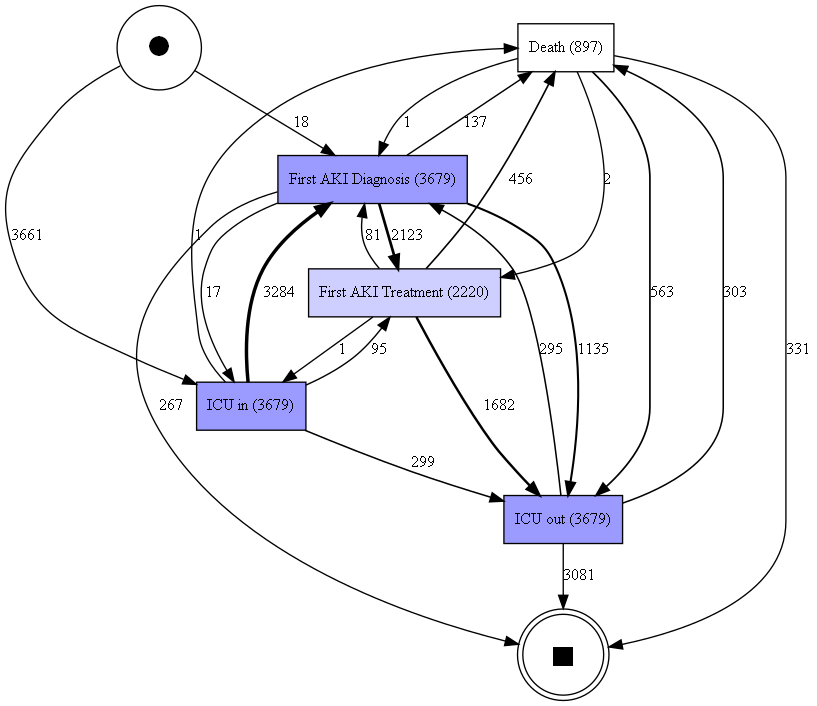

In [47]:
i4.discover_dfg_model()
i4.view_dfg()

## Iteration 5

Using the event log, answer RQ1.

In [48]:
# Start from iteration 4
i5 = i4.copy()

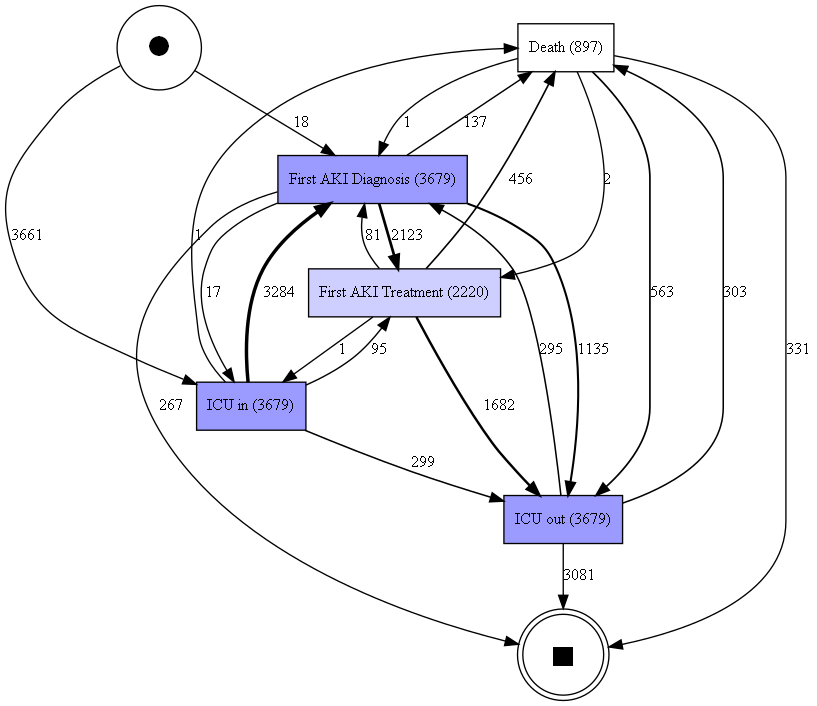

In [49]:
i5.discover_dfg_model()
i5.view_dfg()

In [50]:
i5.sa

{'ICU in': 3661, 'First AKI Diagnosis': 18}

In [51]:
i5.ea

{'ICU out': 3081, 'Death': 331, 'First AKI Diagnosis': 267}

In [52]:
variants = i5.get_variants()
variants

Variant  Count  \
Variant #                                                             
1          ICU in,First AKI Diagnosis,First AKI Treatment...   1481   
2                         ICU in,First AKI Diagnosis,ICU out    966   
3          ICU in,First AKI Diagnosis,First AKI Treatment...    455   
4                         ICU in,ICU out,First AKI Diagnosis    267   
5          ICU in,First AKI Diagnosis,First AKI Treatment...    186   
6                   ICU in,First AKI Diagnosis,ICU out,Death    107   
7                   ICU in,First AKI Diagnosis,Death,ICU out     87   
8          ICU in,First AKI Treatment,First AKI Diagnosis...     53   
9                   ICU in,ICU out,First AKI Diagnosis,Death     28   
10         ICU in,First AKI Treatment,First AKI Diagnosis...     20   
11         First AKI Diagnosis,ICU in,First AKI Treatment...     11   
12         ICU in,First AKI Treatment,First AKI Diagnosis...      8   
13                        First AKI Diagnosis,ICU in,ICU out      3   
14         ICU in,First AKI Diagnosis,Death,First AKI Tre...      2   
15         First AKI Diagnosis,ICU in,First AKI Treatment...      2   
16                  ICU in,Death,First AKI Diagnosis,ICU out      1   
17         First AKI Diagnosis,ICU in,First AKI Treatment...      1   
18         First AKI Diagnosis,First AKI Treatment,ICU in...      1   

           Proportion  Proportion (Cumulative)  
Variant #                                       
1            0.402555                 0.402555  
2            0.262571                 0.665126  
3            0.123675                 0.788801  
4            0.072574                 0.861375  
5            0.050557                 0.911933  
6            0.029084                 0.941017  
7            0.023648                 0.964664  
8            0.014406                 0.979070  
9            0.007611                 0.986681  
10           0.005436                 0.992117  
11           0.002990                 0.995107  
12           0.002175                 0.997282  
13           0.000815                 0.998097  
14           0.000544                 0.998641  
15           0.000544                 0.999185  
16           0.000272                 0.999456  
17           0.000272                 0.999728  
18           0.000272                 1.000000

In [53]:
for index, variant in variants.iterrows():
    print(index, variant["Variant"])

1 ICU in,First AKI Diagnosis,First AKI Treatment,ICU out
2 ICU in,First AKI Diagnosis,ICU out
3 ICU in,First AKI Diagnosis,First AKI Treatment,Death,ICU out
4 ICU in,ICU out,First AKI Diagnosis
5 ICU in,First AKI Diagnosis,First AKI Treatment,ICU out,Death
6 ICU in,First AKI Diagnosis,ICU out,Death
7 ICU in,First AKI Diagnosis,Death,ICU out
8 ICU in,First AKI Treatment,First AKI Diagnosis,ICU out
9 ICU in,ICU out,First AKI Diagnosis,Death
10 ICU in,First AKI Treatment,First AKI Diagnosis,Death,ICU out
11 First AKI Diagnosis,ICU in,First AKI Treatment,ICU out
12 ICU in,First AKI Treatment,First AKI Diagnosis,ICU out,Death
13 First AKI Diagnosis,ICU in,ICU out
14 ICU in,First AKI Diagnosis,Death,First AKI Treatment,ICU out
15 First AKI Diagnosis,ICU in,First AKI Treatment,ICU out,Death
16 ICU in,Death,First AKI Diagnosis,ICU out
17 First AKI Diagnosis,ICU in,First AKI Treatment,Death,ICU out
18 First AKI Diagnosis,First AKI Treatment,ICU in,ICU out


In [54]:
# Top 8 variants
top_n = 8
count = variants.iloc[:top_n]["Count"].sum()
total_count = variants["Count"].sum()
print("The top %d variants account for %d (%.2f%%) cases" % (top_n, count, count*100/total_count))
print("The remaining %d variants account for %d (%.2f%%) cases" % (len(variants.index) - top_n, total_count - count, (total_count - count)*100/total_count))

def variants_count(variants, variants_indices, zero_index=False):
    variants_labels = np.array(variants_indices)
    variants_indices = np.array(variants_indices)
    if not zero_index:
        variants_indices = variants_indices - 1
    else:
        variants_labels = variants_labels + 1
        
    return "Variants %s account for %d cases" % (", ".join((np.array(variants_labels) + 1).astype(str)), variants.iloc[variants_indices]["Count"].sum())
print(variants_count(variants, [1, 3, 5, 8]))
print(variants_count(variants, [2, 4, 6, 7]))

The top 8 variants account for 3602 (97.91%) cases
The remaining 10 variants account for 77 (2.09%) cases
Variants 2, 4, 6, 9 account for 2175 cases
Variants 3, 5, 7, 8 account for 1427 cases


What proportion of cases have treatment?

In [55]:
def filter_treated(case):
    events = [e["concept:name"] for e in case]
    return ("First AKI Diagnosis" in events) and ("First AKI Treatment" in events)

def filter_all_diagnosed(case):
    events = [e["concept:name"] for e in case]
    return ("First AKI Diagnosis" in events)

def treatment_conformance_analysis(iteration):
    treated_cases = pm4py.filter_log(lambda x: filter_treated(x), iteration.pm_log)
    all_diagnosed_cases = pm4py.filter_log(lambda x: filter_all_diagnosed(x), iteration.pm_log)

    num_treated_cases = len(treated_cases)
    num_diagnosed_cases = len(all_diagnosed_cases)
    num_untreated_cases = num_diagnosed_cases - num_treated_cases

    print("%d treated cases vs %d untreated cases" % (num_treated_cases, num_untreated_cases))
    print("%d total (%.2f%% treated)" % (num_diagnosed_cases, (num_treated_cases * 100 / num_diagnosed_cases)))
    
treatment_conformance_analysis(i5)

2220 treated cases vs 1459 untreated cases
3679 total (60.34% treated)


### Removing Sepsis and Fluid Overload Patients

This percentage seems quite low. Dr Aldred suggested ensuring that patients with sepsis and patients with fluid overload are excluded. He also suggested ensuring patients with intrinsic kidney problems are excluded, but we already do this.

In [56]:
sepsis_filter = map_dl[
    (map_dl["ICD9_CODE"].isin(["99591"])) # Sepsis https://en.wikipedia.org/wiki/Sepsis
]
sepsis_admissions = sepsis_filter.merge(diag_dl, left_on="ICD9_CODE", right_on="ICD9_CODE")["HADM_ID"].unique()

i5_sepsis = i5.copy()
sepsis_cases = i5_sepsis.cases["HADM_ID"].isin(sepsis_admissions)
print("There are %d cases with sepsis" % sepsis_cases.sum())

i5_sepsis.set_cases(i5_sepsis.cases[~i5_sepsis.cases["HADM_ID"].isin(sepsis_admissions)])

treatment_conformance_analysis(i5_sepsis)

There are 112 cases with sepsis
2135 treated cases vs 1432 untreated cases
3567 total (59.85% treated)


In [57]:
hypervolemia_filter = map_dl[
    (map_dl["ICD9_CODE"].isin(["2766", "27661", "27669"])) # Hypervolemia https://en.wikipedia.org/wiki/Hypervolemia
]
hypervolemia_admissions = hypervolemia_filter.merge(diag_dl, left_on="ICD9_CODE", right_on="ICD9_CODE")["HADM_ID"].unique()

i5_hypervolemia = i5.copy()
hypervolemia_cases = i5_hypervolemia.cases["HADM_ID"].isin(hypervolemia_admissions)
print("There are %d cases with hypervolemia" % hypervolemia_cases.sum())

i5_hypervolemia.set_cases(i5_hypervolemia.cases[~i5_hypervolemia.cases["HADM_ID"].isin(hypervolemia_admissions)])

treatment_conformance_analysis(i5_hypervolemia)

There are 46 cases with hypervolemia
2192 treated cases vs 1441 untreated cases
3633 total (60.34% treated)


This doesn't seem to account for the unexpectedly low number. Further research is needed from medical professionals.

## Iteration 6

Using the event log, answer RQ1.

### Data Processing

In [58]:
def prepare_ttt_analysis(cases_in, elog, successful_state_cutoff=0.5, treatment_cutoff=0.7):
    cases = cases_in.copy()
    
    # Deteriorations
    cases["HOSPITAL_EXPIRE_FLAG"] = cases["HOSPITAL_EXPIRE_FLAG"].fillna(0).astype(bool)
    cases["ICUSTAY_EXPIRE_FLAG"] = cases["ICUSTAY_EXPIRE_FLAG"].fillna(0).astype(bool)
    cases["Expire Flag"] = cases["HOSPITAL_EXPIRE_FLAG"] | cases["ICUSTAY_EXPIRE_FLAG"]

    # ICU leave time
    icu_out_times = elog[elog["ACTIVITY"].isin(["ICU out"])].groupby("ICUSTAY_ID")["EVENT_TIMESTAMP"].max().rename("ICU Out Time")
    cases = cases.merge(icu_out_times, left_index=True, right_index=True, how="outer")

    # Cap ages at 90 to make mean a little more realistic
    cases["AGE"] = cases["AGE"].mask(cases["AGE"] >= 90, 90)
    
    # Successful State
    successful_state_cutoff_time = cases["Time to Successful State"].quantile(successful_state_cutoff)
    print("Successful state cutoff time", successful_state_cutoff_time)
    cases["AKI Successful State Flag"] = cases["Time to Successful State"] <= successful_state_cutoff_time
    cases["Deterioration Flag"] = ~cases["AKI Successful State Flag"] | cases["Expire Flag"]

    # AKI Treatment
    time_to_treatment = cases["First AKI Treatment Time"] - cases["First AKI Diagnosis Time"]
    treatment_cutoff_time = time_to_treatment.quantile(treatment_cutoff)
    print("Treatment cutoff time", treatment_cutoff_time)
    cases["First AKI Treatment Time"] = cases["First AKI Treatment Time"].mask(
        (cases["First AKI Treatment Time"] >= (cases["First AKI Diagnosis Time"] + treatment_cutoff_time)) | (cases["First AKI Treatment Time"] > (cases["First AKI Diagnosis Time"] + cases["Time to Successful State"])),
        pd.NaT
    )
    cases["Time to Treatment"] = cases["First AKI Treatment Time"] - cases["First AKI Diagnosis Time"]
    cases["Received AKI Treatment"] = ~cases["First AKI Treatment Time"].isna()

    # Add flag for complete playout
    death_flag = cases["Expire Flag"]
    deterioration_flag = ~cases["AKI Successful State Flag"]
    stayed_long_enough_flag = (cases["First AKI Diagnosis Time"] + pd.DateOffset(days=2)) <= cases["ICU Out Time"]
    #aki_recovered_flag = cases["Last AKI Diagnosis Stage (Num)"] < cases["First AKI Diagnosis Stage (Num)"]
    cases["Playout Flag"] = death_flag | deterioration_flag | stayed_long_enough_flag# | aki_recovered_flag
    # cases["Playout Flag"] = stayed_long_enough_flag | aki_recovered_flag
    
    # Remove any cases that do not fully play out
    cases = cases[(cases["Playout Flag"] == True)].copy()
    
    return cases

In [59]:
# Start from iteration 6
i6 = i5.copy()

In [60]:
# Add info about the patient's successful state to the cases table
i6.set_cases(add_success_case_info(i6.cases, i1.pd_log))

In [61]:
i6.set_cases(prepare_ttt_analysis(i6.cases, i6.pd_log, successful_state_cutoff=1, treatment_cutoff=0.95))

Successful state cutoff time 80 days 20:00:00
Treatment cutoff time 3 days 19:30:53.999999999


### Mining and Analysis

In [62]:
ct = i6.cases.groupby(["Received AKI Treatment", "AKI Successful State Flag"]).size().rename("True Count").reset_index()
pivot = ct.pivot(index="Received AKI Treatment", columns="AKI Successful State Flag", values="True Count")
pivot["Total"] = pivot.sum(axis=1)
pivot["Proportion"] = pivot[True] / pivot["Total"]
pivot

AKI Successful State Flag  False  True  Total  Proportion
Received AKI Treatment                                   
False                       1040   341   1381    0.246923
True                         932   944   1876    0.503198

Z test to confirm statistical significance

In [63]:
def ztest(pivot):
    sample_success_a, sample_size_a = pivot.loc[False, True], pivot.loc[False, "Total"]
    sample_success_b, sample_size_b = pivot.loc[True, True], pivot.loc[True, "Total"]

    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])

    from statsmodels.stats.proportion import proportions_ztest
    test = proportions_ztest(count=successes, nobs=samples, alternative="smaller")
    print("Z-Score = %.2f, P-Value = %.3f" % (test[0], test[1]))

print("Diff = %.3f" % (pivot.loc[True, "Proportion"] - pivot.loc[False, "Proportion"]))
ztest(pivot)

Diff = 0.256
Z-Score = -14.79, P-Value = 0.000
